In [1]:
%load_ext autotime

time: 450 µs (started: 2022-04-02 21:05:35 +05:30)


In [2]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
import matplotlib.pyplot as plt

import numpy as np
import shap

time: 1.66 s (started: 2022-04-02 21:05:35 +05:30)


In [3]:
CLASS = datasets.MNIST
ROOT = 'mnist'

time: 268 µs (started: 2022-04-02 21:05:36 +05:30)


In [4]:
batch_size = 128
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x
    
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

train_loader = torch.utils.data.DataLoader(
    CLASS(ROOT, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    CLASS(ROOT, train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size, shuffle=False)

model = Net().to(device)

try:
    model.load_state_dict(torch.load(f'{ROOT}_cnn.pt', map_location='cpu'))
    model = model.to(device)
except FileNotFoundError:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
    for epoch in range(1, num_epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
    torch.save(model.state_dict(), f'{ROOT}_cnn.pt')



time: 1.11 s (started: 2022-04-02 21:05:36 +05:30)


In [5]:
loader = torch.utils.data.DataLoader(
    CLASS(ROOT, train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=10000, shuffle=False)
images, labels = next(iter(loader))

time: 679 ms (started: 2022-04-02 21:05:38 +05:30)


In [6]:
sample_idx = []
for i in range(10):
    sample_idx.append(np.where(labels == i)[0][-1])
sample_idx

[9993, 9994, 9995, 9996, 9997, 9998, 9999, 9990, 9991, 9992]

time: 3.6 ms (started: 2022-04-02 21:05:38 +05:30)


In [7]:
background = images[:9990].to(device)
samples = images[sample_idx].to(device)
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(samples)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


time: 41.1 s (started: 2022-04-02 21:05:38 +05:30)


<Figure size 432x288 with 0 Axes>

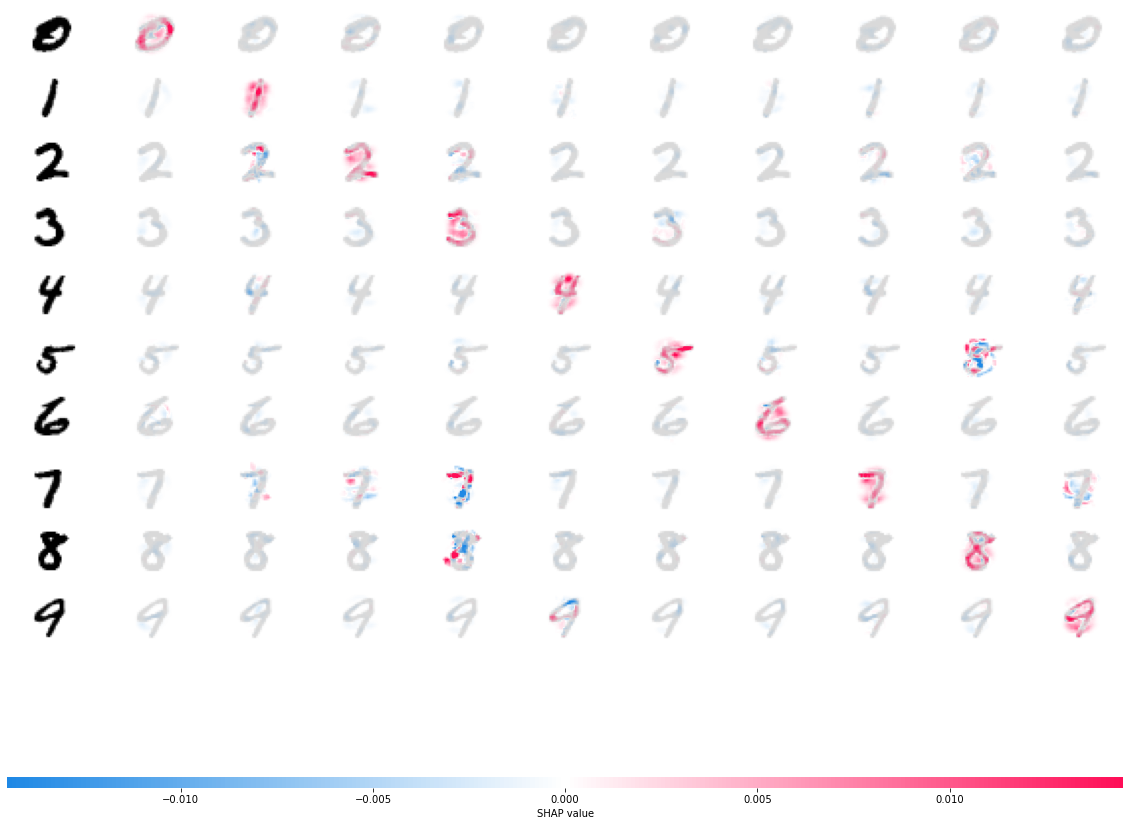

time: 3.33 s (started: 2022-04-02 21:06:19 +05:30)


In [8]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(samples.cpu().numpy(), 1, -1), 1, 2)
plt.figure()
shap.image_plot(shap_numpy, -test_numpy, show=False)
plt.savefig(f'{ROOT}_shap.eps', bbox_inches='tight')
plt.show()